# Verify unpacking CW mode files from EK80

This notebook verifies tests in `test_convert/test_convert_ek80()`.

In [1]:
import os
import shutil
import numpy as np
import xarray as xr
import pandas as pd
from echopype.convert import Convert
from echopype.convert.ek80 import ConvertEK80

In [2]:
os.getcwd()

'/Users/wu-jung/code_git/echopype'

In [4]:
ek80_raw_path = './echopype/test_data/ek80/D20190822-T161221.raw'
ek80_power_test_path = ['./echopype/test_data/ek80/from_echoview/18kHz.power.csv',
                        './echopype/test_data/ek80/from_echoview/38kHz.power.csv',
                        './echopype/test_data/ek80/from_echoview/70kHz.power.csv',
                        './echopype/test_data/ek80/from_echoview/120kHz.power.csv',
                        './echopype/test_data/ek80/from_echoview/200kHz.power.csv']
ek80_angle_test_path = './echopype/test_data/ek80/from_echoview/EK80_test_angles.csv'

In [12]:
tmp = ConvertEK80(ek80_raw_path)
tmp.raw2nc()

12:53:46  converting file: D20190822-T161221.raw


In [13]:
ds_beam = xr.open_dataset(tmp.nc_path, group='Beam')

In [14]:
df = pd.read_csv(ek80_angle_test_path, compression='gzip')

In [15]:
df

,frequency,ping_index,range_bin,minor,major
0,18000,1,0,-0.090726,-0.090726
1,18000,1,1,0.000000,0.000000
2,18000,1,2,0.000000,0.000000
3,18000,1,3,0.000000,0.000000
4,18000,1,4,0.000000,0.000000
...,...,...,...,...,...
537385,200000,3,35821,NaN,NaN
537386,200000,3,35822,NaN,NaN
537387,200000,3,35823,NaN,NaN
537388,200000,3,35824,NaN,NaN


In [16]:
major = (ds_beam['angle_athwartship'] * 1.40625 / ds_beam['angle_sensitivity_athwartship'] -
         ds_beam['angle_offset_athwartship'])[:, 1:4, :]
minor = (ds_beam['angle_alongship'] * 1.40625 / ds_beam['angle_sensitivity_alongship'] -
         ds_beam['angle_offset_alongship'])[:, 1:4, :]

In [17]:
for f in np.unique(df['frequency']):
    print(f)

18000
38000
70000
120000
200000


In [29]:
f=18000

In [30]:
major_test = []
minor_test = []
df_freq = df[df['frequency'] == f]
for i in np.unique(df_freq['ping_index']):
    val_maj = df_freq[df_freq['ping_index'] == i]['major']
    val_min = df_freq[df_freq['ping_index'] == i]['minor']
    major_test.append(xr.DataArray(val_maj, coords=[('range_bin', np.arange(val_maj.size))]))
    minor_test.append(xr.DataArray(val_min, coords=[('range_bin', np.arange(val_min.size))]))

In [31]:
major_test[0]

<xarray.DataArray 'major' (range_bin: 35826)>
array([-0.0907258,  0.       ,  0.       , ...,  2.08669  ,  2.90323  ,
        3.81048  ])
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 ... 35821 35822 35823 35824 35825

In [44]:
major.sel(frequency=f).isel(ping_time=0)

<xarray.DataArray (range_bin: 35826)>
array([-0.09072581,  0.        ,  0.        , ...,  2.0866935 ,
        2.903226  ,  3.810484  ], dtype=float32)
Coordinates:
    frequency  float32 18000.0
    ping_time  float64 3.775e+09
  * range_bin  (range_bin) int64 0 1 2 3 4 5 ... 35821 35822 35823 35824 35825

In [43]:
major_test[0]

<xarray.DataArray 'major' (range_bin: 35826)>
array([-0.0907258,  0.       ,  0.       , ...,  2.08669  ,  2.90323  ,
        3.81048  ])
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 ... 35821 35822 35823 35824 35825

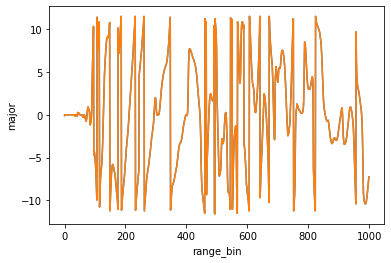

In [46]:
major.sel(frequency=f).isel(ping_time=0,range_bin=slice(0,1000)).plot(x='range_bin')
major_test[0].isel(range_bin=slice(0,1000)).plot(x='range_bin')

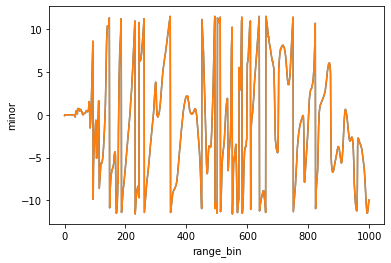

In [47]:
minor.sel(frequency=f).isel(ping_time=0,range_bin=slice(0,1000)).plot(x='range_bin')
minor_test[0].isel(range_bin=slice(0,1000)).plot(x='range_bin')

In [48]:
POWER_FACTOR = 0.011758984205624266  # 10*log10(2)/256
power = ds_beam.backscatter_r * POWER_FACTOR
# single point error in original raw data. Read as -2000 by echopype and -999 by Echoview
power[3][4][13174] = -999
for i, f in enumerate(ek80_power_test_path):
    test_power = pd.read_csv(f, delimiter=';').iloc[:, 13:].values
    assert np.allclose(test_power, power[i].dropna('range_bin'))


In [51]:
f

'./echopype/test_data/ek80/from_echoview/200kHz.power.csv'

In [54]:
test_power = pd.read_csv(f, delimiter=';').iloc[:, 13:].transpose()
test_power

,0,1,2,3,4,5,6
FIELD14,5.950046,6.032359,5.867733,5.867733,6.032359,6.044118,6.044118
FIELD15,8.748684,8.854515,8.701648,8.701648,8.854515,8.854515,8.842756
FIELD16,10.630122,10.759471,10.618363,10.606604,10.747712,10.747712,10.747712
FIELD17,11.876574,11.982405,11.841297,11.841297,11.982405,11.994164,11.994164
FIELD18,12.535077,12.664426,12.535077,12.523318,12.664426,12.664426,12.676185
...,...,...,...,...,...,...,...
FIELD31357,-152.913831,-152.114220,-145.282250,-143.130356,-149.832977,-150.115192,-147.234241
FIELD31358,-152.913831,-152.960867,-147.316554,-143.247946,-153.231323,-147.422385,-149.245028
FIELD31359,-151.773209,-152.502266,-150.456203,-143.588956,-159.040261,-145.576224,-149.927049
FIELD31360,-151.067670,-152.372917,-155.783023,-144.235700,-158.475830,-144.647265,-150.173987


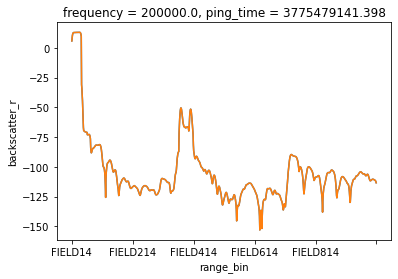

In [69]:
test_power[0].iloc[:1000].plot()
power.sel(frequency=200000).isel(ping_time=0,range_bin=slice(0,1000)).plot()